In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyHalo.preset_models import WDMGeneral, CDM
import pickle
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.Util.param_util import ellipticity2phi_q
from quadmodel.inference.forward_model_packaged import ForwardModelSimulation
from quadmodel.data.quad_base import Quad
import os

seed = 4
np.random.seed(seed)
zlens = 0.5
zsource = 1.5
scale= 1.0
shmf_norm = 0.05 * scale
LOS_norm = 1.0 * scale
cdm_realization = CDM(zlens, zsource,log_mlow=6.0, sigma_sub=shmf_norm, LOS_normalization=LOS_norm,
                     cone_opening_angle_arcsec=6.0)
lens_model_list_halos, redshift_array_halos, kwargs_halos, _ = cdm_realization.lensing_quantities(
    kwargs_mass_sheet={'log_mlow_sheets': 6.0})

In [4]:
np.random.seed(seed)

# data specifics
background_rms = 0.006  # background noise per pixel
exp_time = 1428.0  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
window_size = 3.5
numPix = int(window_size/deltaPix)
fwhm = 0.1  # full width half max of PSF

# PSF specification
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

# macromodel specification
delta_phi_m3 = np.random.uniform(-np.pi/6, np.pi/6)
delta_phi_m4 = 0.0
a3a = np.random.normal(0.0, 0.005)
a4a = np.random.normal(0.0, 0.01)
e1, e2 = np.random.normal(0.0, 0.15), np.random.normal(0.0, 0.15)
phi_m, q = ellipticity2phi_q(e1, e2)
gamma = np.random.normal(2.0, 0.1)
lens_model_list_macro_data = ['EPL_MULTIPOLE_M3M4', 'SHEAR']
kwargs_lens_macro_data = [{'theta_E': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': e1, 'e2': e2,'gamma':gamma, 
                          'a4_a': a4a, 'a3_a': a3a, 'delta_phi_m3': delta_phi_m3, 'delta_phi_m4': delta_phi_m4},
                            {'gamma1': -0.01,'gamma2':0.09}]

print(kwargs_lens_macro_data)


# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 10, 'R_sersic': 0.2, 'n_sersic': 4.0, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

ra_source = 0.06
dec_source = -0.02
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [{'amp': 40.382, 'center_x': ra_source, 'center_y': dec_source, 'e1': 0.37, 
                   'e2': 0.13, 'R_sersic': 0.367, 'n_sersic': 1.0}]
source_model_class = LightModel(source_model_list)

# from paltas.Sources.cosmos import COSMOSCatalog
# from pyHalo.Cosmology.cosmology import Cosmology
# cosmo = Cosmology()
# colossus_cosmo = cosmo.colossus
# cosmos_folder = os.getenv('HOME')+'/data/cosmo_catalog/COSMOS_23.5_training_sample/'
# source_parameters = {'minimum_size_in_pixels': 10.0,
#                      'faintest_apparent_mag': -18, 
#                      'max_z': 0.025,
#                      'smoothing_sigma': 0.001,
#                      'cosmos_folder': cosmos_folder,
#                      'random_rotation': 0.0,
#                      'min_flux_radius': 0.0,
#                      'output_ab_zeropoint': 25.95,
#                      'z_source': zsource,
#                      'center_x': ra_source,
#                      'center_y': dec_source}
# cosmo = COSMOSCatalog(colossus_cosmo, source_parameters)
# idx_source = 1
# source_model_list, kwargs_source, zsource_list = cosmo.draw_source(idx_source)
# source_model_class = LightModel(light_model_list=source_model_list)
# #print(kwargs_source)
# #kwargs_source[0]['image'] *= 0.3
# plt.imshow((kwargs_source[0]['image']))

kwargs_lens_data = kwargs_lens_macro_data + kwargs_halos
lens_model_list_data = lens_model_list_macro_data + lens_model_list_halos
lens_redshift_list = [zlens]*len(lens_model_list_macro_data)+list(redshift_array_halos)
lens_model_class_data = LensModel(lens_model_list=lens_model_list_data, lens_redshift_list=lens_redshift_list,
                                 multi_plane=True, z_source=zsource)

[{'theta_E': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.14902045524131477, 'e2': 0.16189838398964046, 'gamma': 2.145162560647839, 'a4_a': 0.0004500167278941548, 'a3_a': 0.002251807533098353, 'delta_phi_m3': 0.48907250375086353, 'delta_phi_m4': 0.0}, {'gamma1': -0.01, 'gamma2': 0.09}]


9.70326855112309
[5.1207985  5.22847917 5.41861705 2.92272106]
[1.0210281  1.05815861 0.57075494]


(-1.5, 1.5)

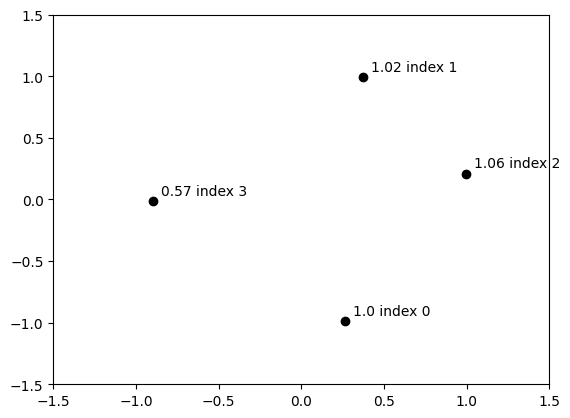

In [5]:
np.random.seed(seed)

lensEquationSolver = LensEquationSolver(lens_model_class_data)
x_image, y_image = lensEquationSolver.image_position_from_source(ra_source, dec_source, kwargs_lens_data)
ext = LensModelExtensions(lens_model_class_data)

source_size_pc_midIR = np.random.uniform(1.0, 10.0)
print(source_size_pc_midIR)
mag_midIR = ext.magnification_finite_adaptive(x_image, y_image, ra_source, dec_source, kwargs_lens_data, source_size_pc_midIR, zsource)
mag_midIR = np.abs(mag_midIR)  # ignore the sign of the magnification
print(mag_midIR)
print(mag_midIR[1:]/mag_midIR[0])

for i, (xi, yi, mi) in enumerate(zip(x_image, y_image, mag_midIR/mag_midIR[0])):
    plt.scatter(xi, yi, color='k')
    plt.annotate(str(np.round(mi,2))+' index '+str(i), xy=(xi+0.05, yi+0.05))

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

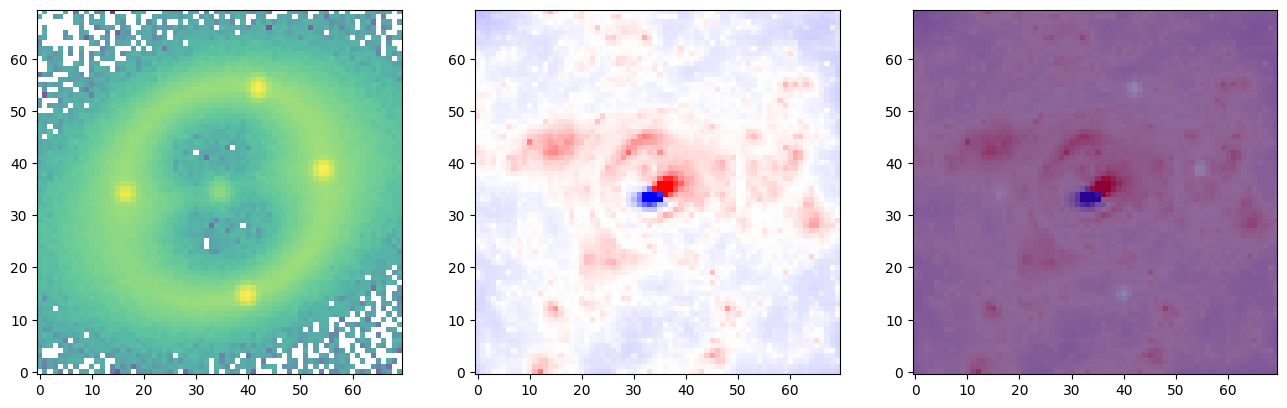

In [6]:
np.random.seed(seed)

source_brightness_intrinsic = 5.0
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': mag_midIR * source_brightness_intrinsic}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class_data, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim_raw = imageModel.image(kwargs_lens_data, kwargs_source, kwargs_lens_light, kwargs_ps)
image_sim = imageModel.image(kwargs_lens_data, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

_r = np.linspace(-window_size/2, window_size/2, numPix)
_xx, _yy = np.meshgrid(_r, _r)
inds = np.where(np.hypot(_xx, _yy)>3.0)
mask = np.ones_like(kwargs_data['image_data'])
mask[inds] = 0.0

shape0 = _xx.shape
lens_model_macro = LensModel(lens_model_list_macro_data)
kappa_macro = lens_model_macro.kappa(_xx.ravel(), _yy.ravel(), kwargs_lens_macro_data).reshape(shape0)
kappa = lens_model_class_data.kappa(_xx.ravel(), _yy.ravel(), kwargs_lens_data).reshape(shape0)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

fig = plt.figure(1)
fig.set_size_inches(16, 8)
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
ax1.imshow(np.log10(image_sim * mask), origin='lower', alpha=0.75)

residual_kappa = kappa-kappa_macro
mean = np.mean(residual_kappa[np.where(np.hypot(_xx, _yy)>0.2)])
ax2.imshow(residual_kappa-mean, origin='lower', vmin=-0.1, vmax=0.1,cmap='bwr',alpha=1.)

ax3.imshow(image_sim * mask, origin='lower', alpha=1.,vmin=0.0, vmax=30)
ax3.imshow(residual_kappa-mean, origin='lower', vmin=-0.1, vmax=0.1,cmap='bwr',alpha=0.4)
#print(kwargs_data)
# ext = LensModelExtensions(lens_model_class_data)
# ra_crit_list, dec_crit_list, _, _ = ext.critical_curve_caustics(kwargs_lens_data, compute_window=window_size,
#                                                                     grid_scale=0.01)
# np.savetxt('mock_'+str(seed)+'_critcurves.txt', X=np.append(ra_crit_list[0], dec_crit_list[0]))

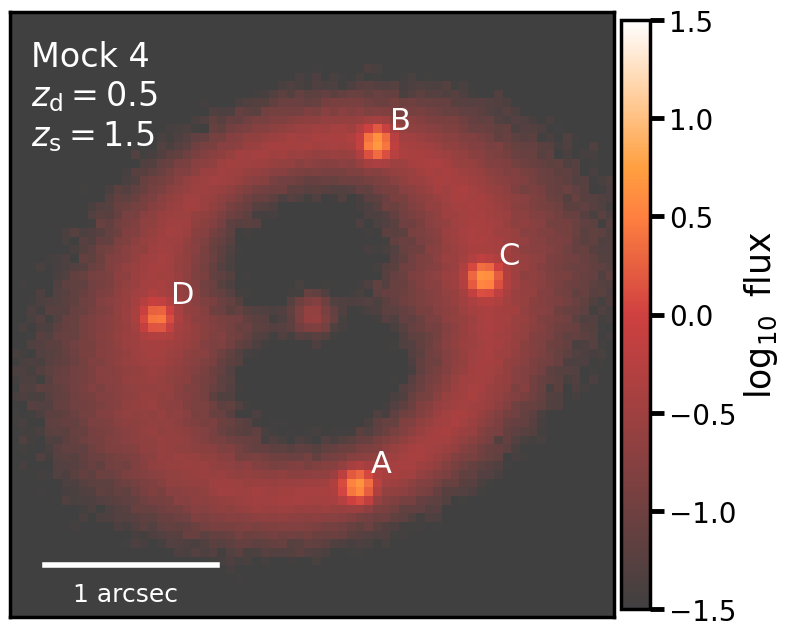

In [7]:
from samana.plotting_util import mock_lens_data_plot, mock_substructure_plot

mock_lens_data_plot(image_sim, window_size, label='Mock 4', zd=zlens, zs=zsource, save_fig=True,
                    filename='mock_4_2038_image.pdf', x_image=x_image, y_image=y_image)

num_pixels_kappa = 200
# mock_substructure_plot(x_image, y_image, window_size, num_pixels_kappa, lens_model_class_data, LensModel(lens_model_list_macro_data), 
#                       kwargs_lens_data, kwargs_lens_macro_data, label='Mock 4', save_fig=True, 
#                        filename='mock_4_kappa.pdf')


In [8]:
np.random.seed(seed)
print('x: ', repr(x_image))
print('y: ', repr(y_image))

flux_uncertainty = 0.03
flux_measurement_error = np.random.normal(0.0, mag_midIR*flux_uncertainty)
fluxes = mag_midIR + flux_measurement_error
print('true magnifications: ', repr(mag_midIR))
print('flux measurement errors: ', repr(flux_measurement_error))
print('measured magnifications: ', repr(fluxes))

x:  array([ 0.26197365,  0.37192752,  0.99587974, -0.89833527])
y:  array([-0.98968167,  0.99370493,  0.21072101, -0.01553163])
true magnifications:  array([5.1207985 , 5.22847917, 5.41861705, 2.92272106])
flux measurement errors:  array([ 0.00776749,  0.07841955, -0.16189347,  0.06081585])
measured magnifications:  array([5.12856599, 5.30689872, 5.25672358, 2.98353691])


In [9]:
from samana.data_util import create_image_data_file

filename = os.getenv('HOME')+'/Code/samana/samana/Data/ImageData/mock_4_2038.py'
image_data = kwargs_data['image_data']
create_image_data_file(filename, image_data, None, None)